# CNN Histopathologic Cancer Detection 

## Overview
This notebook is a practice of utilizing the TensorFlow and Keras to build a Convolutional Neural Network (CNN) for predicting cancer detection from digital pathology images. The practice is based on a Kaggle competition, and the data can be obtained from the competition website at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.

This notebook can also be found at https://github.com/Lorby04/msds/tree/main/dl/week3 and https://www.kaggle.com/code/lorbybi/cnn-histopathologic-cancer-detection

1. Data preparing

Downloading data from the source, extract the compressed files to local disk.
The original image is in tiff format which is not supported by tensorflow. Although there's other packages can handle the format, but it requires mandy dependecies which makes the image loading tasks being complex. To simplify the procedure, finally I converted the tiff image to jpeg format with the package Pillow. 
After the images are prepared, I'm planning to use the Keras API "image_dataset_from_directory()" to create tensorflow dataset from the directory. The API requires the directories to be organized hierarchically with subdirectory to be the name of the class_name or label. So, the hierarchical directory is created along with the downloading/converting/saving procedure as the implemention in the below cells.

In [54]:
# import required libraries
import pathlib
import os
import sys
import concurrent.futures

import pandas as pd
from PIL import Image

import numpy as np
import random as rn

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

from timeit import default_timer as timer

In [55]:
class Constants:
    QUICK_TEST = False
    MAX_FILES = sys.maxsize
    TARGET_SIZE = [96,96]
    BATCH_SIZE = 32
    RETRAIN_MODEL = False
    
class Config():
    def __init__(self):
        self.dataset_url = "https://www.kaggle.com/competitions/histopathologic-cancer-detection/data"
        self.data_root_dir =  "/kaggle/input/mayo-clinic-strip-ai/"
        self.working_dir = "/kaggle/working/"
        self.temp_dir = "/kaggle/working/temp/"

        if os.path.exists("/kaggle"):
            print("Working in kaggle notebook enviorment")
        else:
            print("Working locally")
            self.data_root_dir =  "./histopathologic-cancer-detection/"
            self.working_dir = self.data_root_dir
            self.temp_dir = './hpcd/'

        self.temp_train_dir = self.temp_dir + "train/"
        self.temp_test_dir = self.temp_dir + "test/"
        
        self.data_dir = self.data_root_dir

        self.train_csv =  self.data_dir + "train_labels.csv"
        self.test_csv = None #self.data_dir + "test.csv"

        self.origin_train_dir = "./histopathologic-cancer-detection/train"
        self.origin_test_dir = "./histopathologic-cancer-detection/test"

        self.train_dir = self.temp_train_dir #self.data_dir + "train/"
        self.test_dir = self.temp_test_dir #self.data_dir + "test/"

        self.dir_true = self.train_dir + "1/"
        self.dir_false = self.train_dir + "0/"

        self.origin_train_path = pathlib.Path(self.origin_train_dir).with_suffix('')
        self.origin_test_path = pathlib.Path(self.origin_test_dir).with_suffix('')

        self.train_path = pathlib.Path(self.train_dir).with_suffix('')
        self.test_path = pathlib.Path(self.test_dir).with_suffix('')
    #Convert the image from tif to jpg
    #Move train data to subclass directory
    def new_dir(directory):
        cmd = "mkdir " + directory
        os.system(cmd)
  
    def download_data(self):
        if not os.path.exists(self.data_dir):
            cmd = "pip install opendatasets"
            os.system(cmd)
            import opendatasets as od
            od.download(self.dataset_url)
            
            new_dir(data_dir)
            new_dir(train_dir)
            new_dir(test_dir)
            new_dir(dir_true)
            new_dir(dir_false)
        

In [56]:
config = Config()
config.download_data()

Working locally


Subdir'0' mapps to the label 0 and subdir '1' mapps to the label 1

## Exploratory Data Analysis (EDA)
The original data includes two sets, one for traning, the other one for testing. The preparing procedure put the training data to the train_dir/{class_name}, the testing data is put to the test_dir.
In the following sections, we will have initial analysis and visualization of the data.

In [57]:
class Df():
    def __init__(self, 
                 cfg:Config
                ):
        self.train_df = pd.read_csv(cfg.train_csv).dropna()
        self.test_df = None if cfg.test_csv == None else pd.read_csv(cfg.test_csv)

    def combine_train_set(self):
        pass
    def glance_at(self, df):
        print("\nQuick view of {} data set".format(df))
        if df == 'train':
            print(self.train_df)
            self.train_df.info()
            print('Target values:')
            
            vc = self.train_df['label'].value_counts()     
            print(vc)
            plt.pie(vc,autopct='%1.1f%%')
            plt.legend(vc.index, loc='best')
            plt.show()
        elif df == 'test' and self.test_df != None:
            print(self.test_df)
            self.test_df.info()
        else:
            pass
            
    def glance(self):
        self.glance_at('train')
        #self.glance_at('test')


Quick view of train data set
                                              id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64

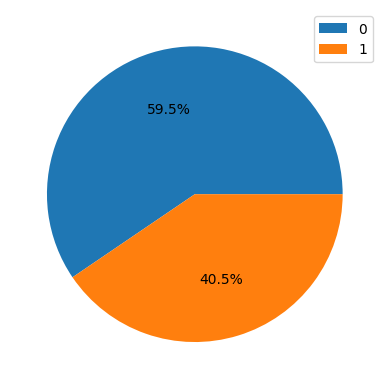

In [58]:
df = Df(config)
df.glance()

The number of images for tranning is 220,025, and also verify the name is as expected.

In [59]:
def check_create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        pass
   

class ImageRawDataInDisk:
    def __init__(self, 
                 df, 
                 from_path,
                 to_path,
                 target_size = Constants.TARGET_SIZE, 
                 quick_test = Constants.QUICK_TEST):
        self.df = df # List of df
        self.from_path = from_path
        self.to_path = to_path
        self.target_size = target_size
        self.is_training = False
        self.max_images = Constants.MAX_FILES
        if df is not None:
            self.max_images = min(len(df), Constants.MAX_FILES)
            self.is_training = 'label' in self.df.columns
        self.quick_test = quick_test
        if (quick_test):
            self.max_images = 4 if df is None else min(4, len(df))
        self.loaded_images = 0
        self.skipped_images = 0
    
        
class ImageLoaderToDisk:    
    def build(df, 
             from_path,
             to_path,
             target_size = Constants.TARGET_SIZE, 
             quick_test = Constants.QUICK_TEST):
        owner = ImageRawDataInDisk(df, 
                 from_path,
                 to_path,
                 target_size, 
                 quick_test)
        check_create_dir(to_path)
        loader = ImageLoaderToDisk(owner)
        loader.load()
        return loader
    
    def __init__(self, owner = None):
        self._owner = owner
        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner
                
        
    def load_image(self, from_file, to_file):
        backup = Image.MAX_IMAGE_PIXELS
        Image.MAX_IMAGE_PIXELS = None

        with Image.open(from_file) as f:
            img = f.resize(self.owner().target_size,Image.Resampling.LANCZOS)
            img.save(to_file)

        Image.MAX_IMAGE_PIXELS = backup
        return True

    # The loading is done in a separated process
    # Since the notebook is designed to be run in sequencial mode, no lock is needed
    def load_one(self, from_file, to_file):
        return (self.load_image, from_file, to_file)

    # load all images in the specified directory, resize to small size, store the resized copy
    def load(self):       
        start = timer()

        self.owner().loaded_images = 0
        self.owner().imgs = [None]*self.owner().max_images
        
        loop_start = timer()
        
        to_dir = self.owner().to_path
        indice = rn.sample(range(0, len(self.owner().df)), self.owner().max_images)
        for i in indice:
            id = self.owner().df.loc[i]['id']
            if self.owner().is_training:
                label = self.owner().df.loc[i]['label']
                to_dir = self.owner().to_path + str(label) + "/"
            else:
                assert(to_dir == self.owner().to_path)

            check_create_dir(to_dir)
            to_file = to_dir + str(id) + ".jpg"
            if os.path.exists(to_file):
                self.owner().skipped_images += 1
                self.owner().loaded_images += 1
                continue
                
            from_file = self.owner().from_path + str(id) + '.tif'    
            self.load_one(from_file, to_file)
            self.owner().loaded_images += 1
            print('.', end = ' ')
        
        elapsed = timer() - start

        print("{} images are loaded from {} to {} in {} seconds, {} are skipped among which.".format(
            self.owner().loaded_images, self.owner().from_path, self.owner().to_path, elapsed,
            self.owner().skipped_images
        ))
            
    def show_images(self):
        files = None
        for dirname,_, filenames in os.walk(self.owner().to_path):
            for filename in filenames:
                fullname = os.path.join(dirname, filename)
                if files == None:
                    files = [fullname]
                else:
                    files.append(fullname)
                    
        num = min(16, len(files))
        fig = plt.figure(figsize=(16,16))
        fig_width = 4
        fig_height = num//4
        
        num = fig_height * fig_width
        ax = fig.subplots(fig_height,fig_width)
        
        indice = rn.sample(range(0, len(files)), num)
        #print(indice)
        for i in range(len(indice)):
            with Image.open(files[indice[i]]) as img:
                ax[i//fig_height][i%fig_width].imshow(img)
                ax[i//fig_height][i%fig_width].set_title("With Cancer" if "/1/" in files[indice[i]] else "No Cancer")
                i += 1
                if i >= num:
                    return
    
    def statistics(self):
        print("{} images are loaded from {} to {}, {} are skipped among which.".format(
            self.owner().loaded_images, self.owner().from_path, 
            self.owner().to_path, self.owner().skipped_images
        ))


In [60]:
# Use alias to try different options
ImageData = ImageRawDataInDisk
ImageLoader = ImageLoaderToDisk

In [61]:
train_images = ImageLoader.build(df.train_df, config.origin_train_dir, config.temp_train_dir).owner()

220025 images are loaded from ./histopathologic-cancer-detection/train to ./hpcd/train/ in 15.781595375000506 seconds, 220025 are skipped among which.


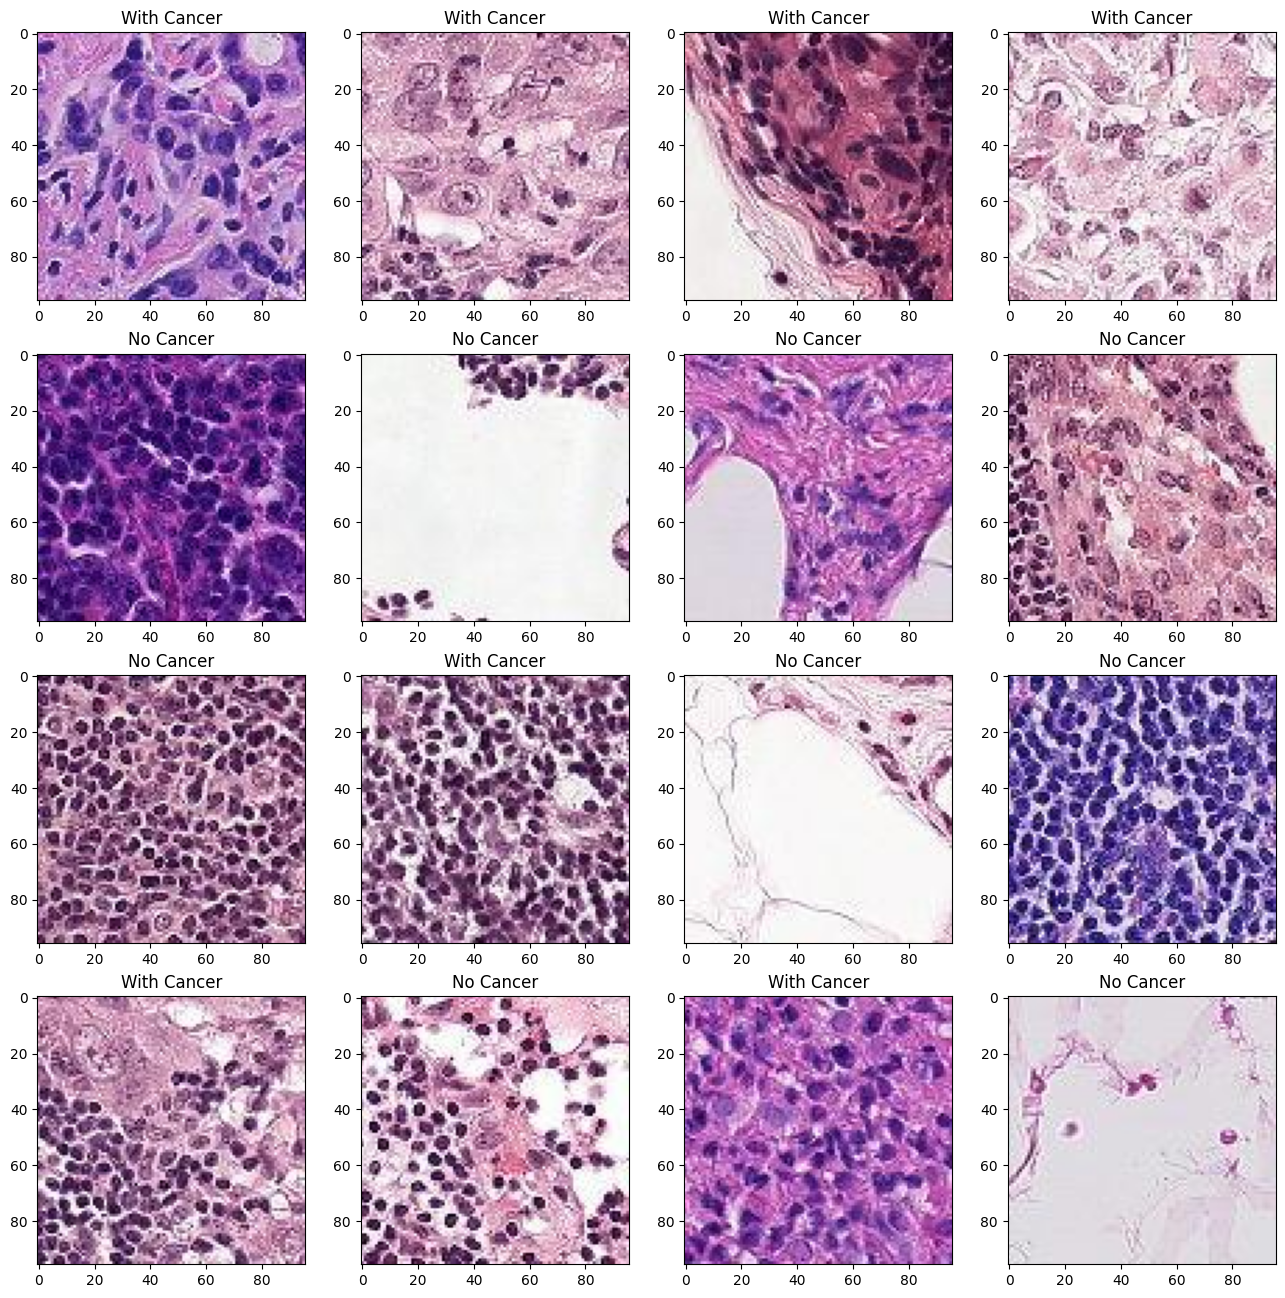

In [62]:
train_image_loader = ImageLoader(train_images)
train_image_loader.show_images()

In [63]:
class DatasetFromDisk:
    def __init__(self, imgs, training_ratio = 0.8):
        self.ds_from = imgs[0].to_path 
        assert(self.ds_from != None)
        self.is_training = imgs[0].is_training
        self.training_ratio = training_ratio if training_ratio > 0 and  training_ratio <= 1 else 0.8

        self.train_ds_ = None
        self.val_ds_ = None
        self.test_ds_ = None
        
        self.is_preprocessed = False
        
        
class DatasetBuilderFromDisk:
    def build(imgs, training_ratio = 0.8):
        owner = DatasetFromDisk(imgs, training_ratio)
        
        builder = DatasetBuilderFromDisk(owner)
        builder.build_dataset()
        return builder
    
    def __init__(self,owner = None): # MUST set owner before using
        self._owner = owner

        
    def reset_owner(self, owner):
        self._owner = owner
        
    def owner(self):
        return self._owner

    
    def build_dataset(self):
        if self.owner().is_training:
            self.owner().train_ds_ = tf.keras.utils.image_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="training",
                seed=123,
                image_size=Constants.TARGET_SIZE,
                batch_size=Constants.BATCH_SIZE,
                shuffle=True
            )
        
            self.owner().val_ds_ = tf.keras.utils.image_dataset_from_directory(
                self.owner().ds_from,
                validation_split=1-self.owner().training_ratio,
                subset="validation",
                seed=123,
                image_size=Constants.TARGET_SIZE,
                batch_size=Constants.BATCH_SIZE,
                shuffle = True
            )
        else:
            pass
        self.pre_process()

    def pre_process(self):
        return #Don't perform preprocess
        if self.owner().is_preprocessed:
            return
        
        preprocessor = tf.keras.Sequential(
            [
                tf.keras.layers.Rescaling(scale=1./255),
            ]
        )
        
        if self.owner().train_ds_ != None :
            self.owner().train_ds_  = self.owner().train_ds_.map(lambda x, y: (preprocessor(x), y))
            
        if self.owner().val_ds_ != None :
            self.owner().val_ds_  = self.owner().val_ds_.map(lambda x, y: (preprocessor(x), y))
        
        if self.owner().test_ds_ != None :
            self.owner().test_ds_  = self.owner().test_ds_.map(lambda x, y: (preprocessor(x), y))
        
        self.owner().is_preprocessed = True
        return

    def train_ds(self):
        return self.owner().train_ds_
    
    def val_ds(self):
        return self.owner().val_ds_    
    
    def test_ds(self):
        return self.owner().test_ds_
    
    def show_train_images(self, ds):
        num = 16
        fig = plt.figure(figsize=(16,16))
        fig_width = 4
        fig_height = num//4
        
        num = fig_height * fig_width
        ax = fig.subplots(fig_height,fig_width)
           
        i = 0
        for imgs, labels in ds:
            #print(imgs)
            #print(labels)
            for img in imgs:
                iax = ax[i//fig_height][i%fig_width]
                iax.imshow(img.numpy().astype("uint8"))
                iax.set_title("Training/Validation")
                i += 1
                if i >= num:
                    return                

    def show_test_images(self, ds):
        num = 16
        fig = plt.figure(figsize=(16,16))
        fig_width = 4
        fig_height = num//4
        
        num = fig_height * fig_width
        ax = fig.subplots(fig_height,fig_width)
        i = 0
        for b in ds:
            for img in b:
                iax = ax[i//fig_height][i%fig_width]
                iax.imshow(img.numpy().astype("uint8"))
                iax.set_title("Test image")
                i += 1
                if i >= num:
                    return  
                
    def show_images(self):
        if self.owner().train_ds_ != None:
            self.show_train_images(self.owner().train_ds_)
            plt.title("Training Images")
            plt.show()
            assert(self.owner().val_ds_ != None)
            self.show_train_images(self.owner().val_ds_)
            plt.title("Validation Images")
            plt.show()
        else:
            assert(self.owner().test_ds_ != None)
            self.show_test_images(self.owner().test_ds_)
            plt.title("Testing Images")
            plt.show()    
    def statistics(self):
        print("Shape of the dataset:")
        for image_batch, labels_batch in self.owner().train_ds_:
            print(image_batch.shape)
            print(labels_batch.shape)
            break

Take some of the training images to be shown on the screen, the first set are positive images and the second set are negative images. 

In [64]:
Dataset = DatasetFromDisk
DatasetBuilder = DatasetBuilderFromDisk

In [65]:
ds = DatasetBuilder.build([train_images]).owner()

Found 220025 files belonging to 2 classes.
Using 176021 files for training.
Found 220025 files belonging to 2 classes.
Using 44004 files for validation.


In [66]:
ds_loader = DatasetBuilder(ds)

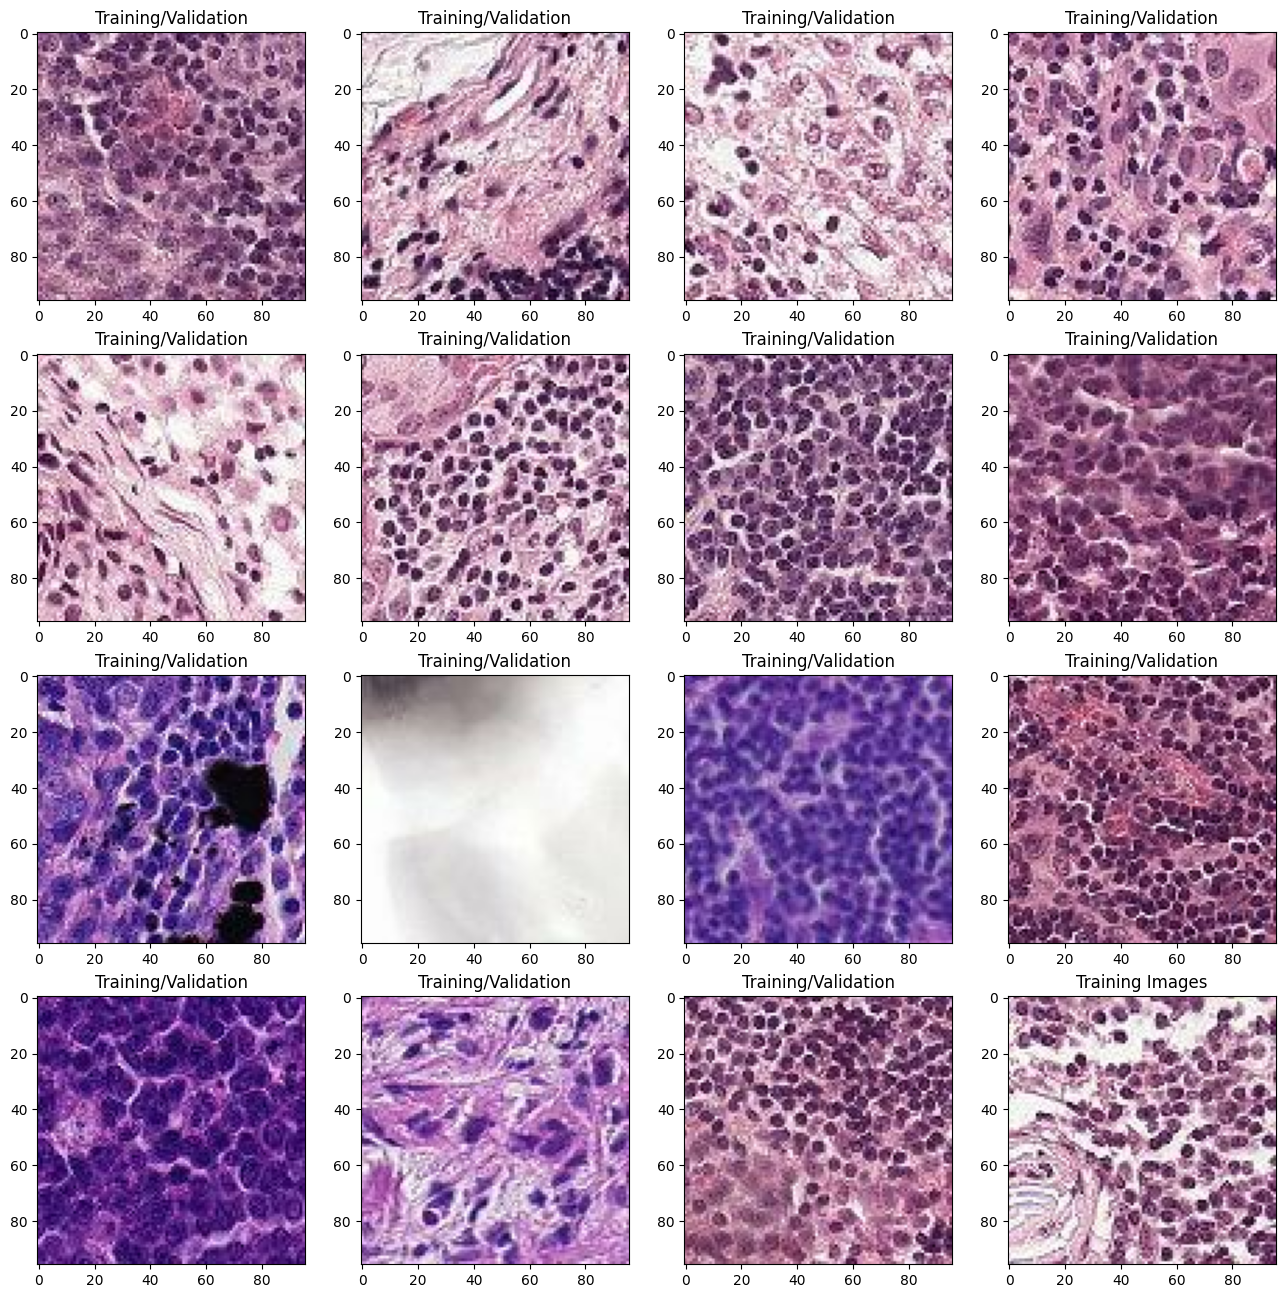

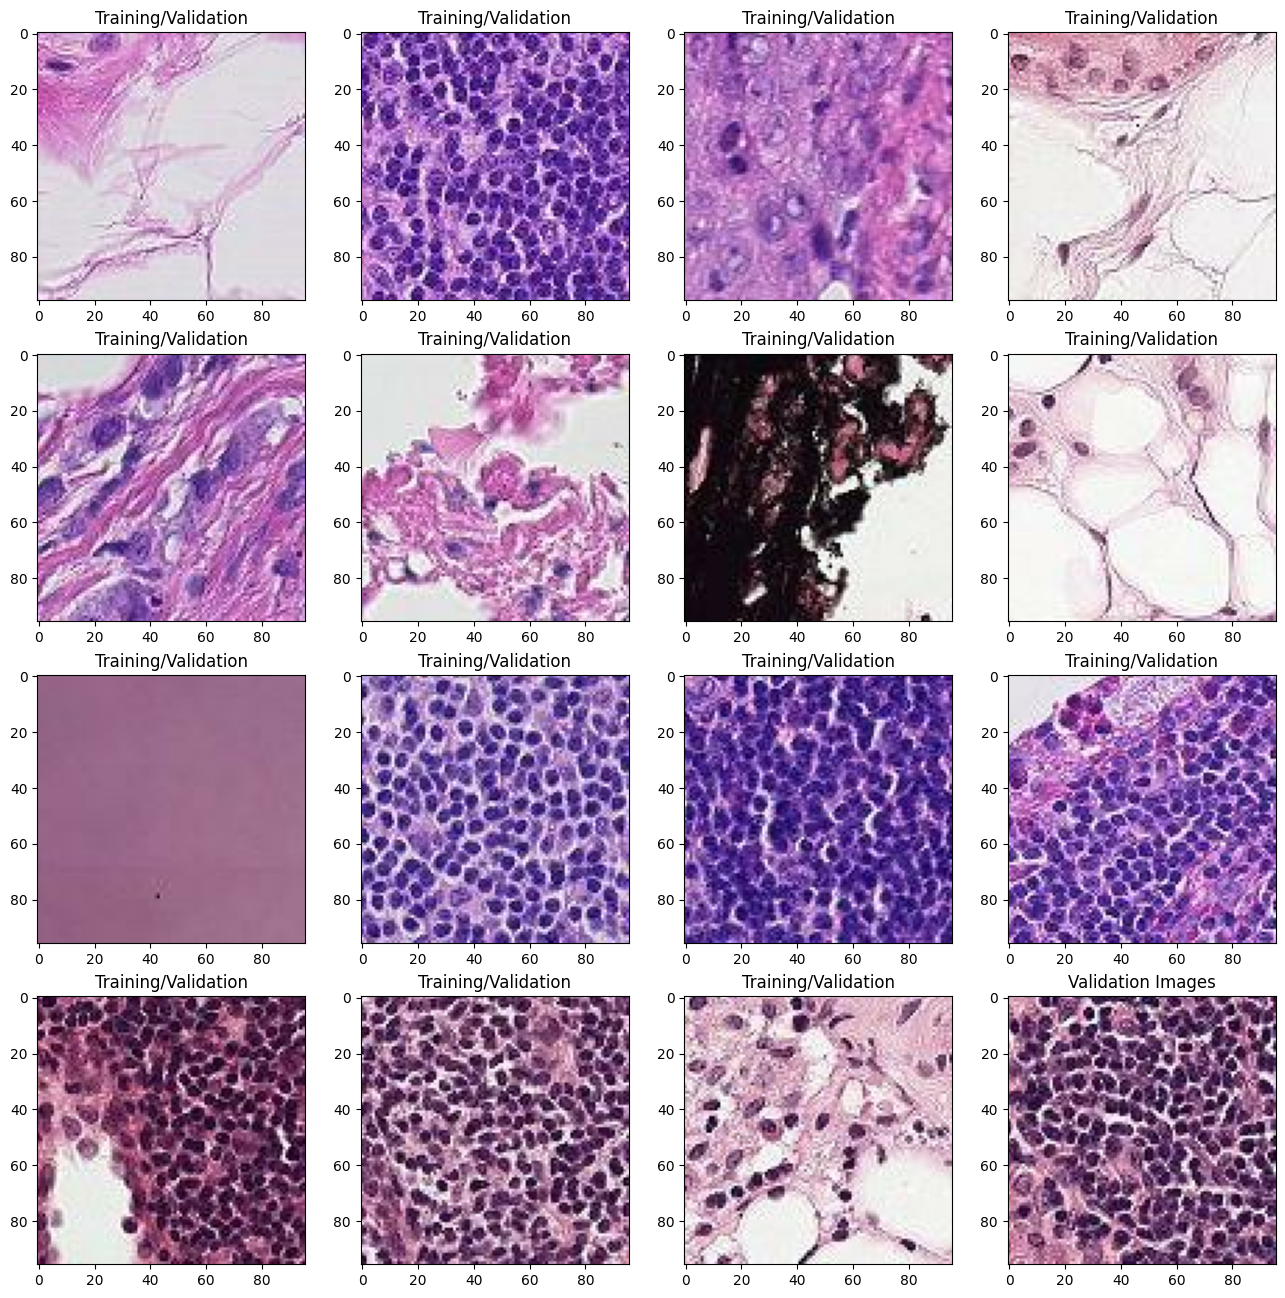

In [67]:
ds_loader.show_images()

To process the mimages, we need to know the size attibute of the images, it's (96,96) as shown below.

Generate then load the training image dataset with image_dataset_from_directory API from the directory. Split 20% from the dataset to be used for validation.

In [68]:
ds_loader.statistics()

Shape of the dataset:
(32, 96, 96, 3)
(32,)


In [69]:
ds.train_ds_.class_names

['0', '1']

## NN Model Architecture 
The high level architecture of the training network are referring to the tensorflow training material with functional models. On top of the referrd architecture, in this practice, several different modles with changing the hyper parameters such as different activation function and different loss funtion are tried to find the best one.
To have better performance, preloaded mecahnism is included.

In [70]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
class Model:
    def __init__(self, ds):
        self.ds = ds
        self.history = None        
        self.opt = Adam()
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metrics = ['accuracy']
        self.callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)]

        self.model = self.build_model()
        
    def fit(self, ds = None, epochs = 10):
        if ds == None:
            ds = self.ds
        self.history = self.model.fit(
            ds.train_ds_.cache().prefetch(buffer_size=tf.data.AUTOTUNE), 
            validation_data = ds.val_ds_.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
            epochs = epochs,
            callbacks = self.callbacks
        )

    def build_model(self):
        input_shape = ds.train_ds_.element_spec[0].shape[1:]
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=input_shape),  
            tf.keras.layers.Rescaling(1./255, input_shape=input_shape),
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            #tf.keras.layers.RandomRotation(0.2),


            #Core layers
            tf.keras.layers.Conv2D(96, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(96, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(96, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            #Add L2 regulation and dropout layer to avoid overfitting
            #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
            #             activation='elu'),

            #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
            #             activation='elu'),
            #layers.Dropout(0.5),
            #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
            #             activation='elu'),
            #layers.Dropout(0.5),
            #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
            #             activation='elu'),
            #layers.Dropout(0.5),

            tf.keras.layers.Dense(128, activation='sigmoid'),
            #tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(len(self.ds.train_ds_.class_names))
        ])    
        model.compile(
            optimizer = self.opt,
            loss = self.loss,
            metrics = self.metrics
        )
        return model
     
    def build_model_functional(self):
        # Input and augument layers
        input_shape = ds.train_ds_.element_spec[0].shape[1:]
        i = tf.keras.layers.Input(shape=input_shape)
        x = i
        x = tf.cast(x, tf.float32)
        #x = tf.keras.layers.RandomRotation(0.2)(x)
        x = tf.keras.layers.RandomFlip()(x)        
        #x = tf.keras.layers.Rescaling(1./255, input_shape=input_shape)(x),

        
        # Core CNN layers
        x = tf.keras.layers.Conv2D(96, 3, activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Conv2D(96, 3, activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D()(x)
        x = tf.keras.layers.Conv2D(96, 3, activation='relu')((x))
        x = tf.keras.layers.MaxPooling2D()(x)




        #Add L2 regulation and dropout layer to avoid overfitting
        #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
        #             activation='elu'),

        #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
        #             activation='elu'),
        #layers.Dropout(0.5),
        #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
        #             activation='elu'),
        #layers.Dropout(0.5),
        #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
        #             activation='elu'),
        #layers.Dropout(0.5),


        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation='sigmoid')(x)
        o = tf.keras.layers.Dense(len(self.ds.train_ds_.class_names))(x)
        
        m = tf.keras.Model(i,o)
        m.compile(
            optimizer = self.opt,
            loss = self.loss,
            metrics = self.metrics
        )
        return m


In [71]:
class ModelVisualization:
    def __init__(self, model: Model):
        self.model = model
    
    def show_history(self):
        history = self.model.history.history
        fig = plt.figure(figsize=(6,10))
        fig_width = 1
        fig_height = 2
        ax = fig.subplots(fig_height,fig_width)
        
        ax[0].plot(history['accuracy'],'*-')
        ax[0].plot(history['val_accuracy'],"x-")
        ax[0].legend(['train', 'validation'])
        ax[0].set_xlabel("epoch")
        ax[0].set_ylabel('accuracy')
        ax[0].set_title("Accuracies")
        
        
        ax[1].plot(history['loss'],'*-')
        ax[1].plot(history['val_loss'],'x-')
        ax[1].legend(['train', 'validation'])
        ax[1].set_title("Losses")
        ax[1].set_xlabel("epoch")
        ax[1].set_ylabel('loss')
        plt.show()
        

    def summary(self):
        self.model.model.summary()
        self.model.model.get_metrics_result()

In [72]:
m = Model(ds)

Summary of the best model and the corresponding hyper-parameters.

In [73]:
m.fit(epochs=25)


Epoch 1/25


2023-03-03 22:36:23.874869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8073

2023-03-03 22:50:58.998608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 921s 167ms/step - loss: 0.4270 - accuracy: 0.8073 - val_loss: 0.3394 - val_accuracy: 0.8547
Epoch 2/25
5501/5501 [==============================] - 1014s 184ms/step - loss: 0.3175 - accuracy: 0.8653 - val_loss: 0.3126 - val_accuracy: 0.8708
Epoch 3/25
5501/5501 [==============================] - 1487s 270ms/step - loss: 0.2849 - accuracy: 0.8811 - val_loss: 0.2874 - val_accuracy: 0.8812
Epoch 4/25
5501/5501 [==============================] - 1125s 205ms/step - loss: 0.2625 - accuracy: 0.8918 - val_loss: 0.2827 - val_accuracy: 0.8856
Epoch 5/25
5501/5501 [==============================] - 1129s 205ms/step - loss: 0.2430 - accuracy: 0.9002 - val_loss: 0.2895 - val_accuracy: 0.8845
Epoch 6/25
5501/5501 [==============================] - 885s 161ms/step - loss: 0.2245 - accuracy: 0.9083 - val_loss: 0.2934 - val_accuracy: 0.8863
Epoch 7/25
5501/5501 [==============================] - 940s 171ms/step - loss: 0.2043 - accuracy: 0.9172 - val_loss: 0

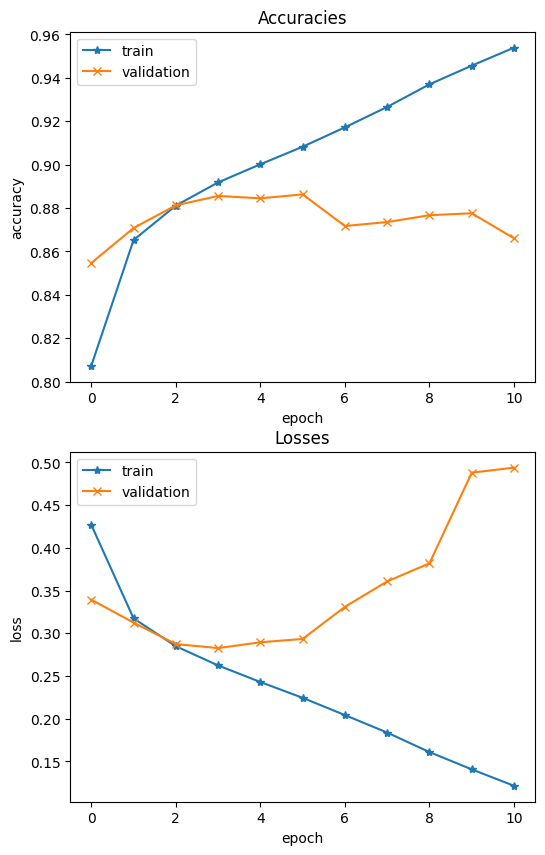

In [74]:
vm = ModelVisualization(m)
vm.show_history()

The early-stop callbacks will cause the training to be stopped when the val_accuracy decreases in two continous rounds. With the early-stop mechanism, it can avoid significant overfitting problem.
To prevent overfitting further, the L2 regularity and drop-out were added initially, but the final result was very bad, so the two groups are removed from the final model.

The model includes the following layers:
1. Preprocessing (Rescale) and augument (Flip) layer
2. Output layer
3. 3 hidden CNN layer with 64*3 nodes per layer and 3 hidden pooling layer
4. Optimization algorithm: Adam
5. Activation function:relu
6. Other parameters: default value

## Test
Same process as dealing with the training images, the testing images are loaded/resized then saved with jpg to a temporary directory.
Afte the preprocessing, a dataset for testing is created, then it is trained with the trained model. Submit the final result as requested.

In [75]:
class Predictor:
    def __init__(self, model: tf.keras.Model, from_path, to_path, classes):
        self.model = model
        self.classes = classes
        #self.model.add(tf.keras.layers.Softmax())
        self.from_path = from_path
        self.to_path = to_path
        self.df = None
        self.prepare()
        self.pred = self.predict()
        self.pred_df = None
        self.build_result_df()
        
        self.submit()
    def prepare(self):
        test_files = np.array(os.listdir(self.from_path))
        self.df = pd.DataFrame(test_files, columns=['id'])
        self.df = self.df.applymap(lambda x: os.path.splitext(x)[0])
        ImageLoader.build(self.df, self.from_path, self.to_path)
        
    def predict(self):
        test_files = np.array(os.listdir(self.to_path))
        self.df = pd.DataFrame(test_files, columns=['image_id'])
        ds_gen = tf.keras.preprocessing.image.ImageDataGenerator()
        ds = ds_gen.flow_from_dataframe(
            self.df,
            self.to_path,
            class_mode=None,
            shuffle= False,
            x_col = 'image_id',
            y_col = None,
            target_size = Constants.TARGET_SIZE
        )

        y_pred_prob = self.model.predict(ds)
        #y_pred = tf.keras.np_utils.probas_to_classes(y_pred_prob)
        return tf.keras.activations.softmax(tf.convert_to_tensor(y_pred_prob))
    
    def build_result_df(self):
        self.pred_df = self.df.applymap(lambda x: os.path.splitext(x)[0])
        
        pred = pd.DataFrame(self.pred.numpy(),columns=self.classes)
        self.pred_df['label'] = pred.apply(np.argmax, axis=1)
  
    def submit(self):
        self.pred_df.to_csv('submission.csv',index=False)


In [76]:
class PredictorDisplay:
    def __init__(self, owner):
        self.owner = owner
        
    def dump(self):
        print("Prediction possibilities:")
        print(self.owner.pred_df)
        print(self.owner.pred_df.label.value_counts())
        
    def show_result(self):
        labels = ['Negative', 'Positive']
        plt.pie(self.owner.pred_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
        plt.show()


Load data and create the dataframe respectively.

In [77]:
predictor = Predictor(m.model, config.origin_test_dir, config.temp_test_dir, ds.train_ds_.class_names)

57458 images are loaded from ./histopathologic-cancer-detection/test to ./hpcd/test/ in 2.9883273749983346 seconds, 57458 are skipped among which.
Found 57458 validated image filenames.
   1/1796 [..............................] - ETA: 7:28

2023-03-04 01:51:50.644932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1796/1796 [==============================] - 60s 33ms/step


In [78]:
disp = PredictorDisplay(predictor)
disp.dump()

Prediction possibilities:
                                       image_id  label
0      1d72b9448e3eb6d1de8d8e6e94f48730f63bfde7      1
1      674d6f5b6a0a6180223f68e3114abf0a140b2225      0
2      4cd8ebe1187041a7a2c1e4f74c75816b4796270a      0
3      887f9067fd159db8f41b7b7f01bbaa1bf407f859      0
4      66458d57360ec266c19e51bf10c1d26f517b1981      0
...                                         ...    ...
57453  e746318251601a3cf3cdde41bcf978633f2bd32c      1
57454  98abc394daaf1bf3fca880b06dc1f2ac93b5a7d5      0
57455  ebc6371413f800533d2808f2f11e900cc4729e64      0
57456  c1171891e0a0c358c9345d84f4b7811a0073fe4f      0
57457  007993203e329bafda75acffc0d0439c930b380c      0

[57458 rows x 2 columns]
0    37980
1    19478
Name: label, dtype: int64


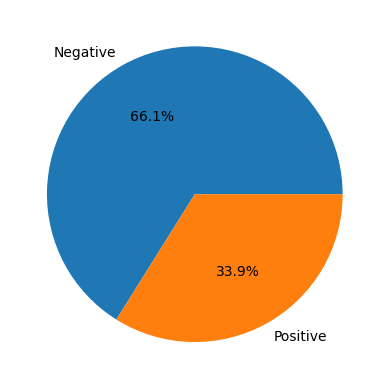

In [79]:
disp.show_result()

Predict. The result of the prediction is the probability of each class_name per record. The probability is mapped to the class_names then put to the dataframe at the end. 

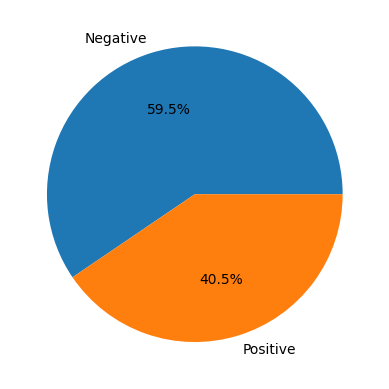

In [80]:
labels = ['Negative', 'Positive']
plt.pie(df.train_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

## Conclusion and Analysis
From the statistics information of training data, the percentage of negative and positive are 60% and 40% respectively. The statistics of the predicted testing data indicates the percentage of negative and positive are 66% and 34% respectively.
As a rough estimation, there's 6% gap between the distribution of the prediction and the real distribution, which means the accuracy of the prediction(testing) is less than 90% (1-6/60), considering there are also some false positive and false negative, the accuracy of the prediction could be around 75% to 80%.
There are some improvements can be applied to get better result.
1. Use tiff format directly.
2. Fine tune with trying more different hyper-parameters 
3. Add rotation and other more image augumentation (it does not work in my environment however)
4. Enhance the network